In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import heapq
import re
import concurrent.futures
from tqdm import tqdm

In [2]:
keyTestTPath = 'data/origin_files/key_test_t.csv'
df = pd.read_csv(keyTestTPath)
# df = df[:1000]

In [3]:
def validate_json(json_str):
    try:
        json.loads(json_str)
        return True
    except:
        return False

def process_row(row):
    if validate_json(row.dimension) and validate_json(row.results):
        return row
    else:
        return None

def judgeJson(keyTestT):
    # 使用并行处理加速处理过程
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_row, keyTestT.itertuples()), total=len(keyTestT)))

    # 过滤掉返回 None 的结果并重置索引
    keyTestT = pd.DataFrame([r for r in results if r is not None])
    keyTestT = keyTestT.reset_index(drop=True)
    return keyTestT


try:
    df = pd.read_csv('data/filterFile.csv', index_col=None)
    print('filterFile.csv exists')
except FileNotFoundError:
    df = df[['results', 'dimension','results_key']]
    df = judgeJson(df)
    df.to_csv('data/filterFile.csv', index=False)
    print('filterFile.csv created')

filterFile.csv exists


In [4]:
filterFilePath = 'data/filterFile.csv'
df = pd.read_csv(filterFilePath)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641861 entries, 0 to 641860
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Index        641861 non-null  int64 
 1   results      641861 non-null  object
 2   dimension    641861 non-null  object
 3   results_key  641861 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.6+ MB


In [6]:
df.head()

,Index,results,dimension,results_key
0,0,"{""#wrk_qps_avg"": 1547599.39, ""wrk_latency_avg""...","{""cvm_cpu"": ""62"", ""platform"": ""qcloud"", ""test_...",test_1kb
1,1,"{""openssl_des_size_16"": 27246690.0, ""openssl_d...","{""cvm_cpu"": ""32"", ""platform"": ""qcloud"", ""test_...",default
2,2,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ...",default
3,3,"{""#ls_time"": 18}","{""dd"": ""name_11"", ""cvm_cpu"": ""1"", ""platform"": ...",default
4,4,"{""#mlc_idle_latency"": 90.6}","{""cvm_cpu"": ""8"", ""platform"": ""default"", ""test_...",specific_actions=idle_latency


In [7]:
def getKeyNum(df):
    # 提取 results 列中带有 "#" 号的字段
    pattern = r'#\w+'  
    results = df['results'].str.cat(sep=' ')  # 将所有 results 列的数据合并为一个字符串
    hashtags = set(re.findall(pattern, results))  # 使用正则表达式提取带 "#" 号的字段，并去重

    # 统计每个带 "#" 号的字段在整个文件中出现的次数
    hashtags_dict = {}
    for hashtag in hashtags:
        count = results.count(hashtag)
        hashtags_dict[hashtag] = count
    return hashtags_dict

def showKeyNum(hashtags_dict):
    # 将字典按值从大到小排序
    hashtags_dict_sorted = sorted(hashtags_dict.items(), key=lambda x: x[1], reverse=True)

    # 提取排序后的键和值
    hashtags_sorted = [item[0] for item in hashtags_dict_sorted]
    counts_sorted = [item[1] for item in hashtags_dict_sorted]

    # 绘制柱状图
    plt.figure(figsize=(180, 25))  
    plt.bar(hashtags_sorted, counts_sorted)  
    plt.xticks(rotation=90)  
    plt.xlabel('Hashtags')  
    plt.ylabel('Counts')  
    plt.title('Hashtags Counts')  
    plt.show()

def getTop10Key(hashtags_dict):
    # 获取字典中数量前十的字段
    top_n = 10  # 自定义获取前几个字段
    top_n_fields = heapq.nlargest(top_n, hashtags_dict, key=hashtags_dict.get)
    
    print("数量前十的字段：")
    for field in top_n_fields:
        print("字段名: {:<30s} 出现次数: {:d}".format(field, hashtags_dict[field]))

In [8]:
hashtags_dict=getKeyNum(df)

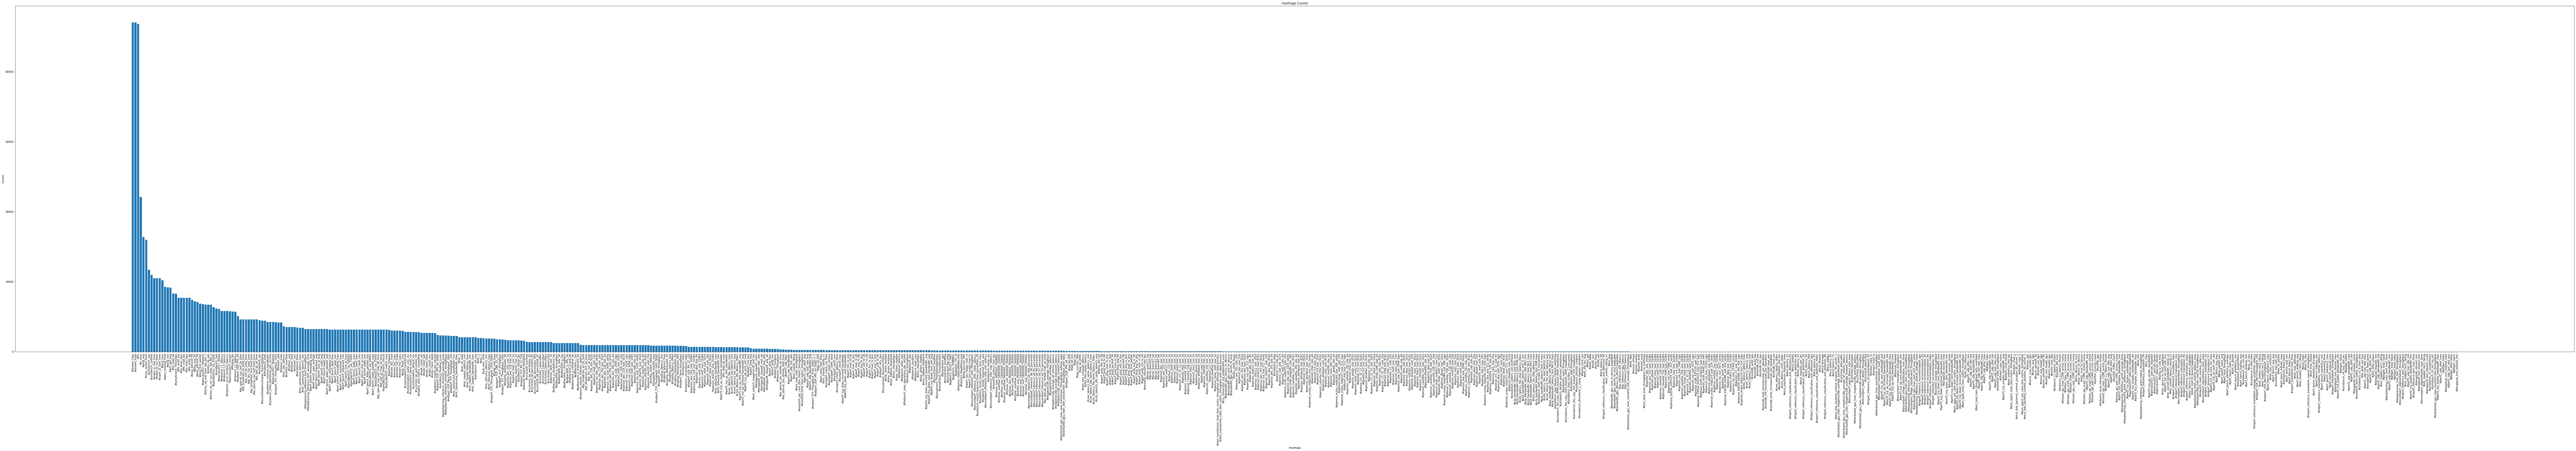

In [9]:
showKeyNum(hashtags_dict)

In [10]:
getTop10Key(hashtags_dict)

数量前十的字段：
字段名: #stream_copy                   出现次数: 94146
字段名: #stream_triad                  出现次数: 94146
字段名: #fio                           出现次数: 93701
字段名: #ls_time                       出现次数: 44230
字段名: #ping_avg                      出现次数: 32848
字段名: #vray_render_time              出现次数: 32004
字段名: #unixbench_cpu                 出现次数: 23444
字段名: #unixbench_context             出现次数: 21977
字段名: #super_pi_real_time            出现次数: 21005
字段名: #super_pi_sys_time             出现次数: 21005


In [11]:
def getValue1(df, field):
    result_dict_values = {}
    result_dict_values[field] = []
    for row in df.itertuples():
        if field in row.results:
            try:
                result = eval(row.results)[field]
                result_dict_values[field].append(result)
            except:
                pass
    return result_dict_values

def getValue2(df, field):
    result_dict_values = {field: df.loc[df['results'].str.contains(field), 'results'].str.extract(r'\"{}\":\s*(\d+)'.format(field), expand=False).dropna().astype(float).tolist()}
    return result_dict_values

In [12]:
#unixbench_cpu
your_field = '#unixbench_cpu'
result_dict_values = getValue1(df, your_field)
outPutDF = pd.DataFrame(result_dict_values)

In [13]:
outPutDF.head()

,#unixbench_cpu
0,2364
1,18835
2,3265
3,317646
4,788652


In [14]:
def getInput(keyTestT, importantKey):
    inputList = []
    keys_to_extract = ['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
    for i in tqdm(range(len(keyTestT))):
        results = json.loads(keyTestT.loc[i, 'results'])
        for result in results:
            if importantKey in result:
                # 将dimension中['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']这几个字段的值提取出来
                dimension = json.loads(keyTestT.loc[i, 'dimension'])
                dimension = json.dumps(dimension)
                templist=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type']
                dimensionJson = json.loads(dimension)
                for key in dimensionJson:
                    if key in templist:
                        key_value = dimensionJson[key]
                        if key=='cvm_memory':
                            key_value=float(key_value.split(' ')[0])
                        elif key=='cvm_cpu':
                            key_value=float(key_value)
                        elif key=='cvm_cpu_qos':
                            key_value='true'
                        templist[keys_to_extract.index(key)]=key_value
                results_key = keyTestT.loc[i, 'results_key']
                templist.append(results_key)
                inputList.append(templist)
                break

    # 将inputList转换为DataFrame
    inputDF = pd.DataFrame(inputList, columns=['cvm_cpu', 'cvm_memory', 'cvm_cpu_qos', 'cvm_os_type', 'results_key'])
    # 判断cvm_cpu和cvm_memory是否是数字，如果不是数字则填写-1
    inputDF['cvm_cpu'] = pd.to_numeric(inputDF['cvm_cpu'], errors='coerce').fillna(-1)
    inputDF['cvm_memory'] = pd.to_numeric(inputDF['cvm_memory'], errors='coerce').fillna(-1)
    return inputDF

In [15]:
inputDF = getInput(df, your_field)


100%|██████████| 641861/641861 [00:13<00:00, 47881.03it/s]


In [16]:
inputDF.head()

,cvm_cpu,cvm_memory,cvm_cpu_qos,cvm_os_type,results_key
0,8.0,40.0,true,CentOS Linux release 7.3.1611 (Core),"gcc_oflag=O0,threads=1"
1,8.0,40.0,true,CentOS Linux release 7.3.1611 (Core),"gcc_oflag=O0,threads=8"
2,124.0,424.0,true,CentOS Linux release 8.2.2004 (Core),"gcc_oflag=O0,threads=1"
3,124.0,424.0,true,CentOS Linux release 8.2.2004 (Core),"gcc_oflag=O0,threads=124"
4,124.0,424.0,true,CentOS Linux release 8.2.2004 (Core),"gcc_oflag=O3,threads=124"


In [17]:
print(inputDF.shape)
print(outPutDF.shape)

(23444, 5)
(23444, 1)


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
import pickle
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve

In [19]:
def showPic(methodName, y_test, y_pred):
    # 创建柱状图
    plt.figure(figsize=(80, 15))

    plt.subplot(1, 2, 1)
    # 创建样本索引数组
    index = np.arange(len(y_test))
    # 绘制线性回归模型的折线图
    plt.plot(index, y_test, label='True Values')
    plt.plot(index, y_pred, label='Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Values')
    plt.title('{}: True Values vs. Predicted Values'.format(methodName))
    plt.legend()
    plt.show()


def showCoef(linear_reg, decision_tree_reg, random_forest_reg, flag=False):
    if (flag):
        if len(linear_reg.coef_) > 1:
            coef_abs = np.abs(linear_reg.coef_)
            sorted_idx = np.argsort(coef_abs)
            print('Linear Regression - Feature Importance (by coefficient absolute value):')
            for idx in sorted_idx:
                print(f'Feature {idx}: {coef_abs[idx]}')
        else:
            print('Linear Regression - No feature importance to print')

        if len(decision_tree_reg.feature_importances_) > 1:
            feature_importances = decision_tree_reg.feature_importances_
            sorted_idx = np.argsort(feature_importances)
            print('Decision Tree - Feature Importance:')
            for idx in sorted_idx:
                print(f'Feature {idx}: {feature_importances[idx]}')
        else:
            print('Decision Tree - No feature importance to print')

        if len(random_forest_reg.feature_importances_) > 1:
            feature_importances = random_forest_reg.feature_importances_
            sorted_idx = np.argsort(feature_importances)
            print('Random Forest - Feature Importance:')
            for idx in sorted_idx:
                print(f'Feature {idx}: {feature_importances[idx]}')
        else:
            print('Random Forest - No feature importance to print')
    else:
         # 绘制特征重要性条形图
        if len(linear_reg.coef_) > 1:
            coef_abs = np.abs(linear_reg.coef_)
            sorted_idx = np.argsort(coef_abs)
            plt.figure(figsize=(150, 20))
            plt.bar(range(len(coef_abs)), coef_abs[sorted_idx])
            plt.xticks(range(len(coef_abs)), sorted_idx)
            plt.xlabel('Feature Index')
            plt.ylabel('Feature Importance (by coefficient absolute value)')
            plt.title('Linear Regression - Feature Importance')
            plt.show()
        else:
            print('Linear Regression - No feature importance to plot')

        if len(decision_tree_reg.feature_importances_) > 1:
            feature_importances = decision_tree_reg.feature_importances_
            sorted_idx = np.argsort(feature_importances)
            plt.figure(figsize=(150, 20))
            plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
            plt.xticks(range(len(feature_importances)), sorted_idx)
            plt.xlabel('Feature Index')
            plt.ylabel('Feature Importance')
            plt.title('Decision Tree - Feature Importance')
            plt.show()
        else:
            print('Decision Tree - No feature importance to plot')

        if len(random_forest_reg.feature_importances_) > 1:
            feature_importances = random_forest_reg.feature_importances_
            sorted_idx = np.argsort(feature_importances)
            plt.figure(figsize=(150, 20))
            plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
            plt.xticks(range(len(feature_importances)), sorted_idx)
            plt.xlabel('Feature Index')
            plt.ylabel('Feature Importance')
            plt.title('Random Forest - Feature Importance')
            plt.show()
        else:
            print('Random Forest - No feature importance to plot')
    

def showDecisonTree(decision_tree_reg, flag=False):
    if flag:    
        plt.figure(figsize=(20, 10))  # 设置画布大小
        plot_tree(decision_tree_reg, max_depth=2, feature_names=None, filled=True, rounded=True)  # 设置最大深度为2，可以根据需要调整
        plt.title('Decision Tree')
        plt.show()


def showRandomForest(random_forest_reg, flag=False):
    if flag:
        if len(random_forest_reg.feature_importances_) > 1:
            # 获取特征重要性
            feature_importances = random_forest_reg.feature_importances_
            # 选择特征重要性最高的决策树
            best_tree_index = np.argmax(feature_importances)
            if best_tree_index >= random_forest_reg.n_estimators:
                best_tree_index = random_forest_reg.n_estimators - 1

            plt.figure(figsize=(20, 10))
            plot_tree(random_forest_reg.estimators_[best_tree_index], max_depth=2, feature_names=None, filled=True, rounded=True)
            plt.title('Best Decision Tree')
            plt.show()
        else:
            print('Random Forest - No feature importance to plot')


def getModel(X_train, y_train, save_path):
    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=5)
    svm_reg = SVR(C=1.0, epsilon=0.1)
    knn_reg = KNeighborsRegressor(n_neighbors=10, weights='uniform')

    # 拟合模型
    linear_reg.fit(X_train, y_train)
    decision_tree_reg.fit(X_train, y_train)
    random_forest_reg.fit(X_train, y_train)
    svm_reg.fit(X_train, y_train)
    knn_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        'linear_reg': linear_reg,
        'decision_tree_reg': decision_tree_reg,
        'random_forest_reg': random_forest_reg,
        'svm_reg': svm_reg,
        'knn_reg': knn_reg
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def train(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)

    # 预测
    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = ['y_pred_linear_reg', 'y_pred_decision_tree_reg', 'y_pred_random_forest_reg', 'y_pred_svm_reg', 'y_pred_knn_reg']
    for i in range(len(models)):
        showPic(models[i], y_test, eval(y_pred[i]))

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg


def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def judgeResult(model, X_train, y_train, X_test, y_test):
    # 在训练集和测试集上计算评估指标
    y_train = y_train.values
    y_test = y_test.values
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print('Model: {}'.format(model.__class__.__name__))
    print('{:<30} {:>10}'.format('Train R2:', '{:.8f}'.format(r2_train)))
    print('{:<30} {:>10}'.format('Test R2:', '{:.8f}'.format(r2_test)))
    
    # 绘制学习曲线
    plot_learning_curve(model, X_train, y_train)

    # 判断过拟合
    if r2_test > r2_train:
        print("模型可能存在过拟合的问题\n\n")
    else:
        print("模型可能没有过拟合的问题\n\n")


def trainOverFit(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = getModel(X_train, y_train, save_path)

    # 预测

    y_pred_linear_reg = linear_reg.predict(X_test)
    y_pred_decision_tree_reg = decision_tree_reg.predict(X_test)
    y_pred_random_forest_reg = random_forest_reg.predict(X_test)
    y_pred_svm_reg = svm_reg.predict(X_test)
    y_pred_knn_reg = knn_reg.predict(X_test)

    # 计算评估指标
    r2_linear_reg = r2_score(y_test, y_pred_linear_reg)
    r2_decision_tree_reg = r2_score(y_test, y_pred_decision_tree_reg)
    r2_random_forest_reg = r2_score(y_test, y_pred_random_forest_reg)
    r2_svm_reg = r2_score(y_test, y_pred_svm_reg)
    r2_knn_reg = r2_score(y_test, y_pred_knn_reg)

    print('{:<30} {:>10}'.format('Linear Regression R2:', '{:.8f}'.format(r2_linear_reg)))
    print('{:<30} {:>10}'.format('Decision Tree R2:', '{:.8f}'.format(r2_decision_tree_reg)))
    print('{:<30} {:>10}'.format('Random Forest R2:', '{:.8f}'.format(r2_random_forest_reg)))
    print('{:<30} {:>10}'.format('SVM R2:', '{:.8f}'.format(r2_svm_reg)))
    print('{:<30} {:>10}'.format('KNN R2:', '{:.8f}'.format(r2_knn_reg)))
    print('\n')

    models = ['Linear Regression', 'Decision Tree Regression', 'Random Forest Regression', 'SVM Regression', 'KNN Regression']
    y_pred = [y_pred_linear_reg, y_pred_decision_tree_reg, y_pred_random_forest_reg, y_pred_svm_reg, y_pred_knn_reg]
    # for i in range(len(models)):
    #     showPic(models[i], y_test, y_pred[i])

    getModelList = [linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg]

    for i in range(len(models)):
        judgeResult(getModelList[i], X_train, y_train, X_test, y_test)

    return linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg



In [20]:
inputDF['cvm_cpu'] = pd.to_numeric(inputDF['cvm_cpu'])
inputDF['cvm_memory'] = pd.to_numeric(inputDF['cvm_memory'])
one_hot_df = pd.get_dummies(inputDF, columns=['cvm_cpu_qos', 'cvm_os_type','results_key'])
X = one_hot_df
y = outPutDF
print(X.shape)
print(y.shape)

(23444, 198)
(23444, 1)


1.  观察训练集和测试集上的模型性能：如果模型在训练集上表现很好但在测试集上表现较差，可能是模型过拟合了。可以通过比较训练集和测试集上的评估指标（如R2分数）来观察模型的性能差异。如果模型在训练集上的性能远远优于测试集，可能存在过拟合的问题。

2.  绘制学习曲线：可以绘制模型的学习曲线，观察模型在训练集和测试集上的性能随着训练样本数量增加而变化。如果模型在训练集上的性能持续提高而在测试集上的性能趋于稳定，可能存在过拟合的问题。

e:\test\envs\pytorch\lib\site-packages\ipykernel_launcher.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
e:\test\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Linear Regression R2:          0.96720129
Decision Tree R2:              0.97961304
Random Forest R2:              0.44617243
SVM R2:                        -0.23171350
KNN R2:                        0.73771561


Model: LinearRegression
Train R2:                      0.95486483
Test R2:                       0.96720129


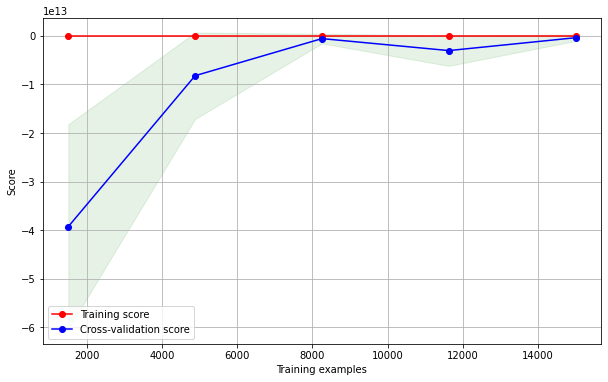

模型可能存在过拟合的问题


Model: DecisionTreeRegressor
Train R2:                      0.97596342
Test R2:                       0.97961304


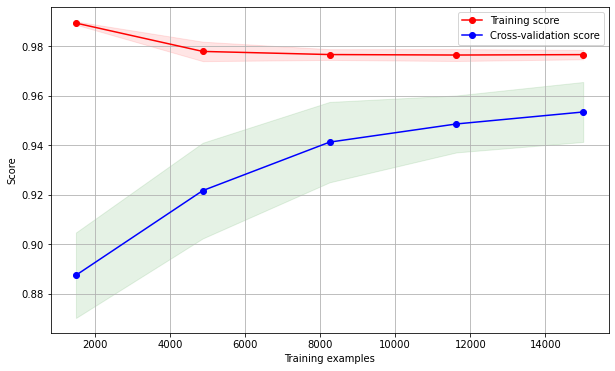

模型可能存在过拟合的问题


Model: RandomForestRegressor
Train R2:                      0.50953356
Test R2:                       0.44617243


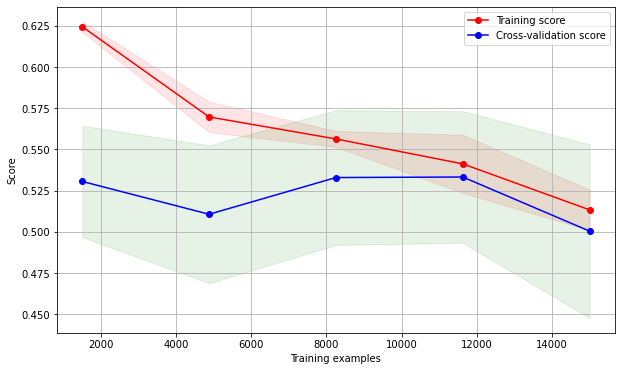

模型可能没有过拟合的问题


Model: SVR
Train R2:                      -0.23109917
Test R2:                       -0.23171350


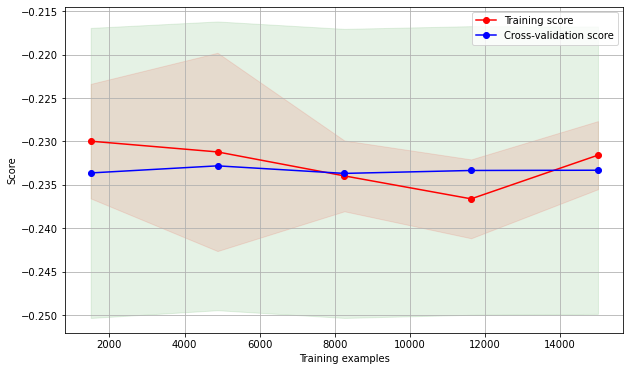

模型可能没有过拟合的问题


Model: KNeighborsRegressor
Train R2:                      0.76557029
Test R2:                       0.73771561


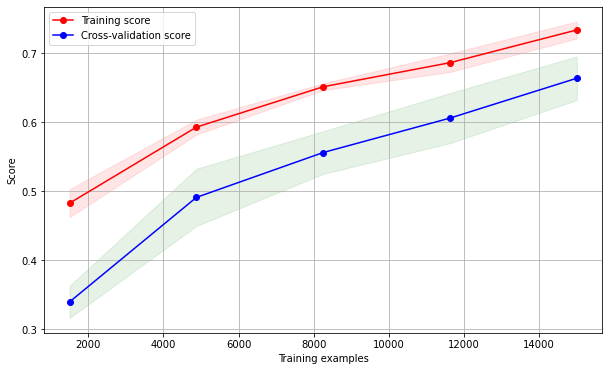

模型可能没有过拟合的问题




In [21]:
save_path = 'model/'
# 判断是否有这个文件夹，没有就创建 
if not os.path.exists(save_path):
    os.makedirs(save_path)

linear_reg, decision_tree_reg, random_forest_reg, svm_reg, knn_reg = trainOverFit(X, y, save_path)

Linear Regression - No feature importance to plot


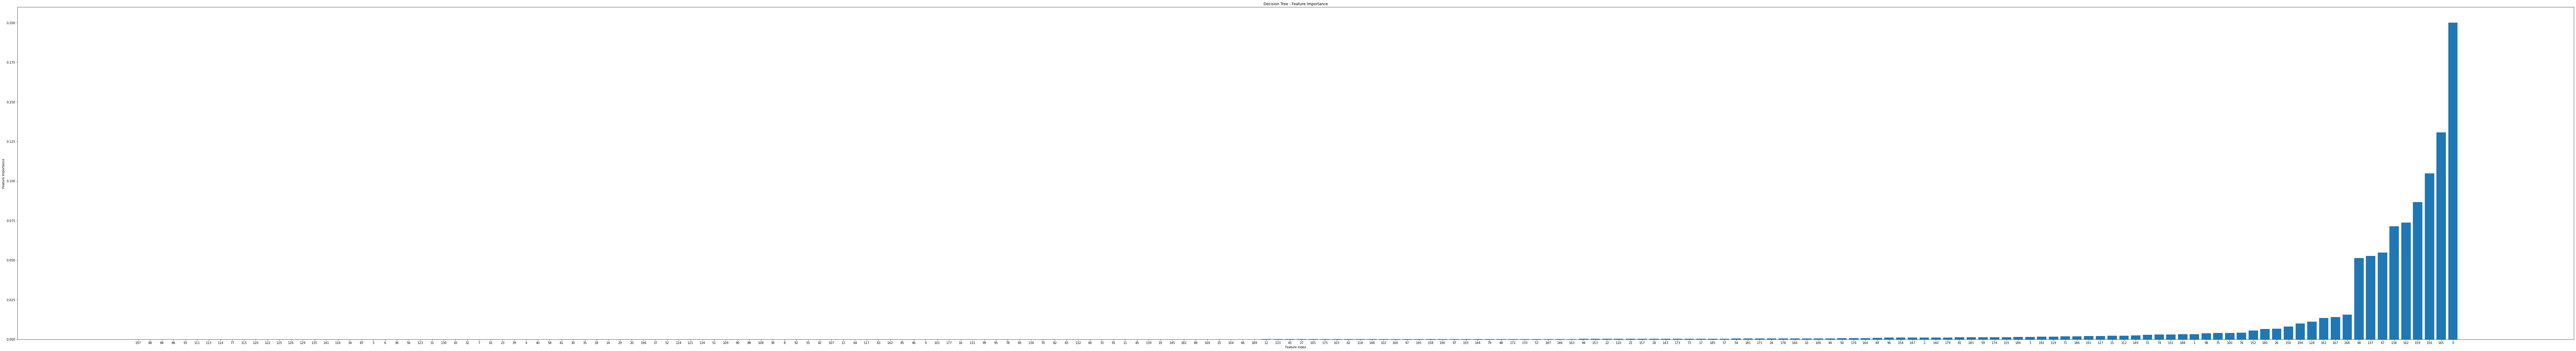

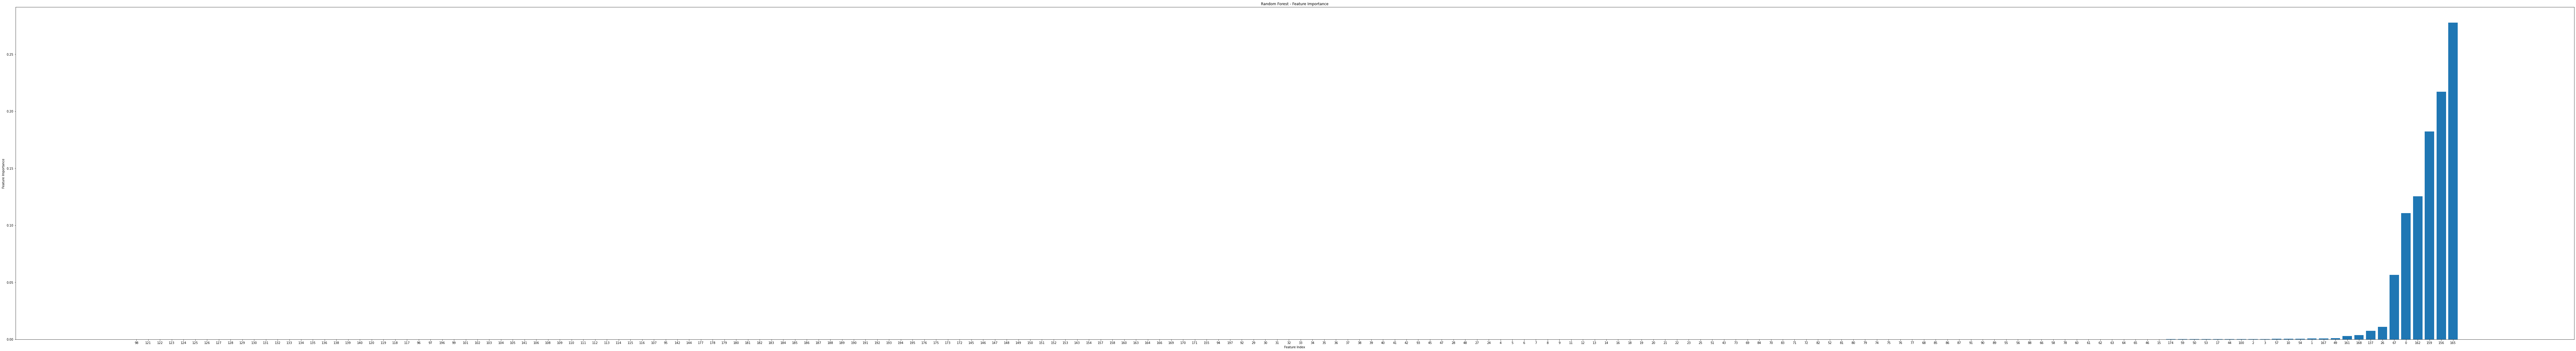

In [22]:
showCoef(linear_reg, decision_tree_reg, random_forest_reg)

In [23]:
flag = True

### 决策树信息理解
x[14]<=0.5：表示该节点的分裂条件，其中 x[14] 表示特征的索引（通常是在训练数据中的列的索引），0.5 是用于划分特征值的阈值。这表示如果样本的第 14 个特征值小于或等于 0.5，则按照左子树的路径进行分裂，否则按照右子树的路径进行分裂。

mse = 123432345：表示该节点的均方误差（Mean Squared Error, MSE），是在该节点处使用的用于评估分裂效果的指标。MSE 是决策树模型常用的一个评估指标，用于衡量当前节点的预测误差。

samples = 35：表示在该节点处参与训练的样本数量，即经过该节点的样本数量。

value = 2132232：表示在该节点处的预测值，通常是该节点处样本的目标变量（或标签）的平均值。这个值可以作为决策树模型对样本的预测结果。

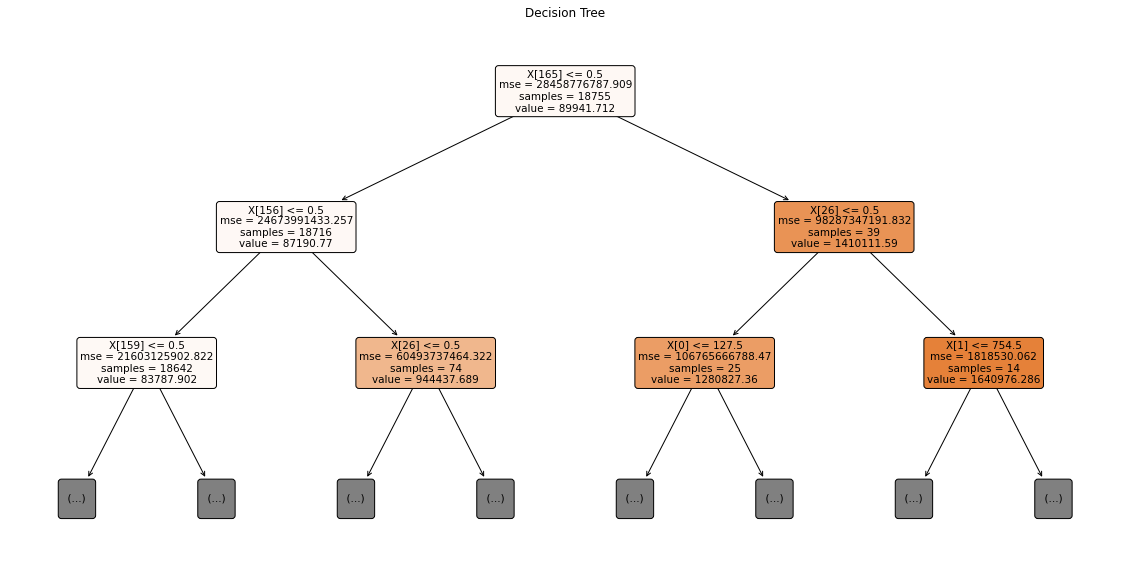

In [24]:
# 打印决策树
showDecisonTree(decision_tree_reg, flag)

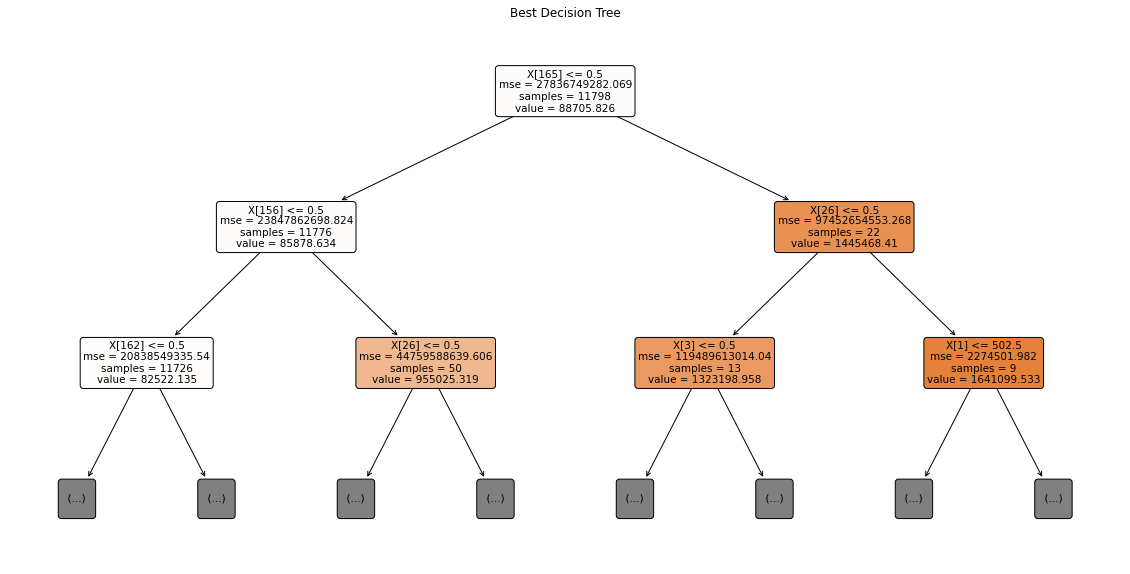

In [25]:
# 打印随机森林
showRandomForest(random_forest_reg, flag)

In [26]:
def processUnknowData1(testX):
    # processUnknowData1用于处理testX数据中所有的类别特征都在训练数据中出现过的情况
    testX_one_hot = pd.get_dummies(testX, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'])
    # 筛选出 testX_one_hot 中在 inputDF 中出现的列
    common_columns = testX_one_hot.columns.intersection(inputDF.columns)
    # 使用筛选后的列重新生成 testX
    testX = testX_one_hot[common_columns]

    # 将训练数据和测试数据合并后再进行独热编码
    combined_df = pd.concat([inputDF, testX], axis=0)
    one_hot_df = pd.get_dummies(combined_df, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 分割合并后的数据，得到编码后的测试数据
    testX = one_hot_df.iloc[-1, :].values.reshape(1, -1)
    print(testX.shape)
    return testX


def processUnknowData2(testX):
    # processUnknowData2用于处理testX数据中可能包含了训练数据集中不存在的类别值
    testDict = {'cvm_cpu': '96', 'cvm_memory': '376', 'cvm_cpu_qos': 'cvm_cpu_qos', 'cvm_os_type': 'CentOS Linux release 7.6.181dsfsd0 (Core)', 'results_key': 'gcc_oflsdfsfdag=O3,threads=1'}

    for i, key in enumerate(testDict.keys()):
        testDict[key] = testX[i]

    max_key_length = max(len(key) for key in testDict.keys())
    for key, value in testDict.items():
        print('key: {:<{}} \tvalue: {}'.format(key, max_key_length, value))

    testDict = pd.DataFrame(testDict, index=[0])
    testDict['cvm_cpu'] = pd.to_numeric(testDict['cvm_cpu'])
    testDict['cvm_memory'] = pd.to_numeric(testDict['cvm_memory'])
    one_hot_df = pd.get_dummies(testDict, columns=['cvm_cpu_qos', 'cvm_os_type', 'results_key'], dummy_na=False)

    # 获取 inputDF 中的特征列顺序
    inputDF_columns = X.columns.tolist()
    # 添加缺失的列，并将其值设置为 0
    missing_columns = list(set(inputDF_columns) - set(one_hot_df.columns))
    for column in missing_columns:
        one_hot_df[column] = 0

    # 按照 inputDF 列的顺序重新排列 one_hot_df
    one_hot_df = one_hot_df[inputDF_columns]

    # 确保编码后的维度与 inputDF 一致
    testX_encoded = one_hot_df.values.reshape(1, -1)
    print(testX_encoded.shape)
    return testX_encoded


def processData(testX, num):
    if num == 1:
        testX = processUnknowData1(testX)
    elif num == 2:
        testX = processUnknowData2(testX)
    else:
        print('num must be 1 or 2')
    return testX


In [27]:
testX = ['8','40','true','CentOS Linux release 7.3.1611 (Core)','gcc_oflag=O0,threads=1']
testY = 2364
testX_encoded = processData(testX, 2)

key: cvm_cpu     	value: 8
key: cvm_memory  	value: 40
key: cvm_cpu_qos 	value: true
key: cvm_os_type 	value: CentOS Linux release 7.3.1611 (Core)
key: results_key 	value: gcc_oflag=O0,threads=1
(1, 198)


In [28]:
def predict(X, load_path):
    # 加载保存的模型
    model = ['linear_reg', 'decision_tree_reg', 'random_forest_reg', 'svm_reg', 'knn_reg']
    result = []
    for model_name in model:
        with open(os.path.join(load_path, model_name + '.pkl'), 'rb') as f:
            models = pickle.load(f)
        preRes = models.predict(X)
        result.append(preRes)

    numbers = [item.item() if isinstance(item, np.ndarray) and item.size == 1 else item for sublist in result for item in sublist]

    predictions = {}
    for i in range(len(model)):
        predictions[model[i]] = numbers[i]

    return predictions


def plot_predictions(predictions, y):
    keys = list(predictions.keys())
    values = list(predictions.values())
    
    plt.figure(figsize=(20, 10))
        
    # 生成 x 轴的位置
    ind = np.arange(len(keys))
    
    # 设置柱状图的宽度
    width = 0.35
    
    # 用 plt 画柱状图，x 轴是 predictions 的 key，y 轴是 predictions 的 value 和 y 的值，一个 x 轴对应两个柱子
    plt.bar(ind, values, width, label='Predictions')
    plt.bar(ind + width, y, width, label='Actual')
    
    # 设置 x 轴标签和标题
    plt.xticks(ind + width / 2, keys)
    plt.xlabel('Model')
    plt.ylabel('Value')
    plt.title('Model Predictions vs Actual Value')
    
    plt.legend()
    plt.show()

In [29]:
predictions = predict(testX_encoded, save_path)

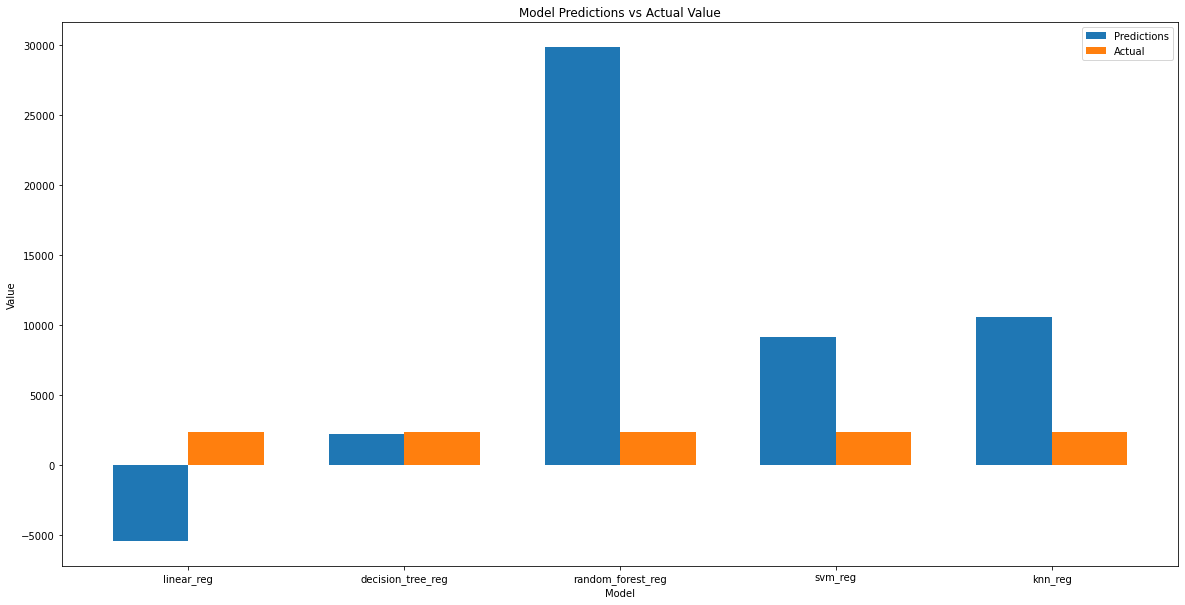

In [30]:
plot_predictions(predictions, testY)

In [31]:
def getMultiModel(X_train, y_train, save_path):
    # 初始化模型
    linear_reg = LinearRegression()
    decision_tree_reg = DecisionTreeRegressor()
    random_forest_reg = RandomForestRegressor(n_estimators=100, max_depth=5)
    svm_reg = SVR(C=1.0, epsilon=0.1)
    knn_reg = KNeighborsRegressor(n_neighbors=10, weights='uniform')

    # 使用MultiOutputRegressor包装模型
    multioutput_linear_reg = MultiOutputRegressor(linear_reg)
    multioutput_decision_tree_reg = MultiOutputRegressor(decision_tree_reg)
    multioutput_random_forest_reg = MultiOutputRegressor(random_forest_reg)
    multioutput_svm_reg = MultiOutputRegressor(svm_reg)
    multioutput_knn_reg = MultiOutputRegressor(knn_reg)

    # 拟合模型
    multioutput_linear_reg.fit(X_train, y_train)
    multioutput_decision_tree_reg.fit(X_train, y_train)
    multioutput_random_forest_reg.fit(X_train, y_train)
    multioutput_svm_reg.fit(X_train, y_train)
    multioutput_knn_reg.fit(X_train, y_train)

    # 保存模型
    models = {
        'multioutput_linear_reg': multioutput_linear_reg,
        'multioutput_decision_tree_reg': multioutput_decision_tree_reg,
        'multioutput_random_forest_reg': multioutput_random_forest_reg,
        'multioutput_svm_reg': multioutput_svm_reg,
        'multioutput_knn_reg': multioutput_knn_reg
    }
    # save_path = 'model/'
    for model_name, model in models.items():
        with open(save_path + model_name + '.pkl', 'wb') as f:
            pickle.dump(model, f)

    return multioutput_linear_reg, multioutput_decision_tree_reg, multioutput_random_forest_reg, multioutput_svm_reg, multioutput_knn_reg


def trainMulti(X, y, save_path):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # 获取模型
    multioutput_linear_reg, multioutput_decision_tree_reg, multioutput_random_forest_reg, multioutput_svm_reg, multioutput_knn_reg = getMultiModel(X_train, y_train, save_path)

    # 预测
    y_pred_multioutput_linear_reg = multioutput_linear_reg.predict(X_test)
    y_pred_multioutput_decision_tree_reg = multioutput_decision_tree_reg.predict(X_test)
    y_pred_multioutput_random_forest_reg = multioutput_random_forest_reg.predict(X_test)
    y_pred_multioutput_svm_reg = multioutput_svm_reg.predict(X_test)
    y_pred_multioutput_knn_reg = multioutput_knn_reg.predict(X_test)

    # 计算评估指标
    r2_multioutput_linear_reg = r2_score(y_test, y_pred_multioutput_linear_reg)
    r2_multioutput_decision_tree_reg = r2_score(y_test, y_pred_multioutput_decision_tree_reg)
    r2_multioutput_random_forest_reg = r2_score(y_test, y_pred_multioutput_random_forest_reg)
    r2_multioutput_svm_reg = r2_score(y_test, y_pred_multioutput_svm_reg)
    r2_multioutput_knn_reg = r2_score(y_test, y_pred_multioutput_knn_reg)
    
    print('{:<30} {}'.format('Multi-Output Linear Regression R2:', r2_multioutput_linear_reg))
    print('{:<30} {}'.format('Multi-Output Decision Tree R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_decision_tree_reg))))
    print('{:<30} {}'.format('Multi-Output Random Forest R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_random_forest_reg))))
    print('{:<30} {}'.format('Multi-Output SVM R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_svm_reg))))
    print('{:<30} {}'.format('Multi-Output KNN R2:', ', '.join('{:.8f}'.format(x) for x in np.nditer(r2_multioutput_knn_reg))))

    print('\n')


In [32]:
your_field1 = '#super_pi_real_time'
result_dict_values1 = getValue1(df, your_field1)
your_field2 = '#super_pi_sys_time'
result_dict_values2 = getValue1(df, your_field2)

result_dict_values1_list = result_dict_values1[your_field1]
result_dict_values2_list = result_dict_values2[your_field2]

# 列名设置为super_pi_real_time和super_pi_sys_time
df1 = pd.DataFrame(result_dict_values1_list, columns=['super_pi_real_time'])
df2 = pd.DataFrame(result_dict_values2_list, columns=['super_pi_sys_time'])
# 将df1和df2合并为df3
outPutDFMulti = pd.concat([df1, df2], axis=1)

In [33]:
outPutDFMulti.head()

,super_pi_real_time,super_pi_sys_time
0,19.947,0.001
1,20.002,0.015
2,19.980,0.001
3,19.953,0.016
4,14.880,0.000


In [34]:
inputDF = getInput(df, your_field1)
print(inputDF.shape)

100%|██████████| 641861/641861 [00:12<00:00, 51360.98it/s]

(21005, 5)


In [35]:
inputDF.head()

,cvm_cpu,cvm_memory,cvm_cpu_qos,cvm_os_type,results_key
0,4.0,8.0,cvm_cpu_qos,CentOS Linux release 7.4.1708 (Core),scale=5000
1,4.0,8.0,cvm_cpu_qos,CentOS Linux release 7.4.1708 (Core),scale=5000
2,4.0,8.0,cvm_cpu_qos,CentOS Linux release 7.4.1708 (Core),scale=5000
3,4.0,8.0,cvm_cpu_qos,CentOS Linux release 7.4.1708 (Core),scale=5000
4,8.0,16.0,cvm_cpu_qos,Tencent tlinux release 2.2 (tkernel3),scale=5000


In [36]:
inputDF['cvm_cpu'] = pd.to_numeric(inputDF['cvm_cpu'])
inputDF['cvm_memory'] = pd.to_numeric(inputDF['cvm_memory'])
one_hot_df = pd.get_dummies(inputDF, columns=['cvm_cpu_qos', 'cvm_os_type','results_key'])
X = one_hot_df
y = outPutDFMulti
print(X.shape)
print(y.shape)

(21005, 62)
(21005, 2)


In [37]:
save_path = 'model/'
# 判断是否有这个文件夹，没有就创建
if not os.path.exists(save_path):
    os.makedirs(save_path)

trainMulti(X, y, save_path)

Multi-Output Linear Regression R2: -184145582042479.75
Multi-Output Decision Tree R2: 0.15032707
Multi-Output Random Forest R2: 0.16748882
Multi-Output SVM R2:           -287.65618042
Multi-Output KNN R2:           0.43347875


